<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-phoenix-assets/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">LLM Ops - Manual Instrumentation</h1>

In this tutorial we will learn how to manually instrument an LLM powered application.

The application processes user input text, utilizing a language model to determine whether the intent behind the input is to make a purchase or to seek information.
* If the intent is identified as a purchase, the application recommends the most suitable product matching the user's preferences.
* Conversely, if the user's intent is to inquire, the application retrieves the most relevant document to provide an accurate answer to the question posed.


⚠️ This tutorial requires an OpenAI key to run

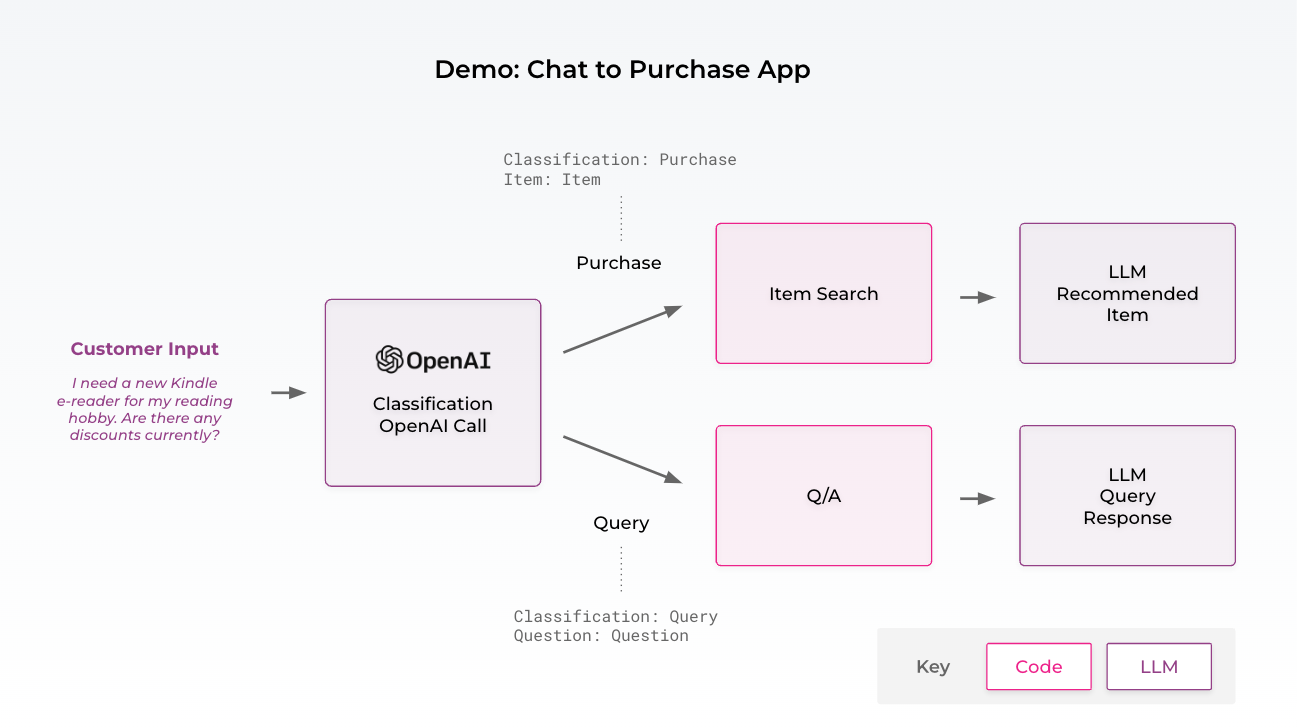

# Install Libraries

In [ ]:
!pip install openai \
  opentelemetry-api \
  opentelemetry-sdk \
  openinference-semantic-conventions \
  openinference-instrumentation-openai \
  opentelemetry-exporter-otlp \
  arize-phoenix

## Import Libraries

In [ ]:
import json
import os
from getpass import getpass
from io import StringIO

import openai
import opentelemetry
import pandas as pd
from openai import OpenAI
from openinference.instrumentation.openai import OpenAIInstrumentor
from openinference.semconv.trace import OpenInferenceSpanKindValues, SpanAttributes
from opentelemetry import trace as trace_api
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk import trace as trace_sdk
from opentelemetry.sdk.resources import Resource
from opentelemetry.sdk.trace.export import SimpleSpanProcessor

## Custom Tracing

Create the tracer provider setup to Phoenix.

In [ ]:
resource = Resource(attributes={})
tracer_provider = trace_sdk.TracerProvider(resource=resource)
span_exporter = OTLPSpanExporter(endpoint="http://localhost:6006/v1/traces")
span_processor = SimpleSpanProcessor(span_exporter=span_exporter)
tracer_provider.add_span_processor(span_processor=span_processor)
trace_api.set_tracer_provider(tracer_provider=tracer_provider)

tracer = trace_api.get_tracer(__name__)

# Because we are using Open AI, we will use this along with our custom instrumentation
OpenAIInstrumentor().instrument()

## Initialize Phoenix UI

This will take a few seconds to start up the UI

In [ ]:
import phoenix as px

px.launch_app()

### Create Sample Data

Sample data is dispersed in three DataFrames:

* `my_items` - Item data (Item, Price (USD),	Description, Stars, Best Use, Material, and Warranty)

* `policy_data` - Policy questions, answers, and category

* `customer_inputs` - Customer questions/ inquiries (Customer ID, Premium Customer, and question)


In [ ]:
my_items = """
Item|Price (USD)|Description|Stars|Best Use|Material|Warranty
Smart LED Light Bulb|$19.99|Control your lights remotely with your phone. Compatible with Alexa and Google Assistant.|4.5|Home automation|Plastic|1 year
Portable Bluetooth Speaker|$39.99|Waterproof, with 10-hour battery life. Connects seamlessly with Bluetooth-enabled devices.|4.3|Outdoor activities|Aluminum|2 years
Stainless Steel Water Bottle|$24.95|Double-walled, vacuum-insulated bottle. Keeps drinks hot for 12 hours and cold for 24 hours.|4.7|Gym and travel|Stainless steel|Lifetime
Wireless Charging Pad|$29.99|Charges compatible smartphones without the need for cables. Sleek design with LED indicator.|4.2|Office and home|Plastic|1 year
Fitness Tracker Watch|$49.95|Tracks steps, heart rate, and sleep quality. Syncs with smartphone for notifications.|4.4|Fitness and health|Silicone|2 years
Resistance Bands Set|$14.99|Set of 5 bands with varying resistance levels. Perfect for home workouts or gym sessions.|4.6|Home and gym|Latex|1 year
Electric Kettle|$34.99|Boils water quickly and efficiently. Auto-shutoff feature for safety. Capacity: 1.7 liters.|4.8|Kitchen|Stainless steel|2 years
Travel Neck Pillow|$19.99|Memory foam pillow with adjustable closure. Provides support during long flights or road trips.|4.5|Travel|Memory foam|1 year
Kindle E-reader|$89.99|High-resolution display with built-in adjustable light. Holds thousands of books. Battery lasts weeks.|4.9|Reading|Plastic|1 year
Reusable Silicone Food Storage Bags|$12.95|Eco-friendly alternative to plastic bags. Dishwasher and microwave safe. Set of 6 in various sizes.|4.7|Kitchen|Silicone|2 years
"""

policy_data = """
Question|Answer|Category
What is your return policy?|Our return policy lasts 30 days. If 30 days have gone by since your purchase, unfortunately, we can’t offer you a refund or exchange. To be eligible for a return, your item must be unused and in the same condition that you received it. It must also be in the original packaging.|Return Policy
How long does delivery take?|Standard delivery times vary by location. Orders within the continental U.S. typically arrive within 3-5 business days. International deliveries can take anywhere from 7-21 business days, depending on customs and local delivery speeds.|Delivery Time
Do you offer international shipping?|Yes, we ship to over 100 countries worldwide. Shipping costs and times vary depending on the destination. All applicable duties and taxes will be paid by the recipient.|International Shipping
Can I change or cancel my order after placing it?|You can change or cancel your order within 1 hour of placing it. Please contact our customer service team as soon as possible. Once the order has moved to the processing stage, we're unable to cancel or make changes.|Order Modification
What payment methods do you accept?|We accept all major credit cards, PayPal, and Apple Pay. For certain countries, we also accept local payment methods; these will be displayed at checkout.|Payment Options
Is it safe to shop on your website?|Absolutely. We use SSL encryption to ensure all your personal information is encrypted before transmission. We do not store credit card details nor have access to your credit card information.|Security
What do I do if my order arrives damaged or incorrect?|Please contact us within 48 hours of receiving your order with photographic evidence of the damage or incorrect item. We will arrange for a replacement or refund as quickly as possible.|Damaged or Incorrect Orders
How can I track my order?|Once your order has been shipped, you will receive an email with a tracking number and a link to track your package.|Order Tracking
Do you offer gift wrapping services?|Yes, we offer gift wrapping for a small additional charge. You can select this option at checkout and include a personalized message if desired.|Gift Services
What is your policy on sustainability and eco-friendliness?|We're committed to reducing our environmental impact. We use eco-friendly packaging and partner with suppliers who prioritize sustainable practices. Additionally, we support various environmental initiatives each year.|Sustainability
"""

customer_inputs = """
Customer ID|Premium Customer|Customer Input
Cust789|Yes|I need a new Kindle E-reader for my reading hobby. Are there any discounts currently?
Cust456|No|Looking for a durable water bottle for my daily runs. Is the Stainless Steel Water Bottle available?
Cust567|Yes|How can I track my Portable Bluetooth Speaker order?
Cust123|Yes|I'm interested in smart home gadgets. Do you have the Smart LED Light Bulb in stock?
Cust234|No|What is your return policy for the Kindle E-reader if I'm not satisfied?
Cust890|No|Do you offer international shipping for the Fitness Tracker Watch?
"""

### Format Customer Data

In [ ]:
items_df = pd.read_csv(StringIO(my_items.strip()), delimiter="|")
policy_df = pd.read_csv(StringIO(policy_data.strip()), delimiter="|")
customer_inputs_df = pd.read_csv(StringIO(customer_inputs.strip()), delimiter="|")

In [ ]:
items_df.head()

In [ ]:
policy_df.head()

In [ ]:
customer_inputs_df.head()

### Input OpenAI API Key

When prompted, enter your API key.

In [ ]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

### Create Prompts

We'll create prompts for tracing data we wish to collect.


* Customer intent prompt - Classifies if the customer is asking about a purchase or general inquiry
* Customer QA Prompt - Prompt to help answer general inquiries
* Item Search Prompt - Prompt about purchase questions

In [ ]:
customer_intent_prompt = """
You are a helpful assistant designed to output JSON. Classify the following customer text as either a 'purchase' or 'query'.

To help define the difference between purchae and query:
- A purchase is a customer asking about a specific item or function of an item with the intent to purchase.
- A query is likely asking about policies on returns, shipping, order modifications, and general inquiries outside of seeking to purchase an item.

Choose the "purchase" category if you see both purchase and query intent.
key: customer_intent
value: 'purchase' or a 'query'

If intent is purchase, append another key 'shopping_category' and the value should be one of the following:
['Fitness and health',
 'Gym and travel',
 'Home and gym',
 'Home automation',
 'Kitchen',
 'Office and home',
 'Outdoor activities',
 'Reading',
 'Travel']

If intent is query, append another key 'query_category' and the value should be one of the following:
['Damaged or Incorrect Orders',
 'Delivery Time',
 'Gift Services',
 'International Shipping',
 'Order Modification',
 'Order Tracking',
 'Payment Options',
 'Return Policy',
 'Security',
 'Sustainability']
"""

customer_qa_prompt = """
You are a helpful assistant designed to output JSON. Assist with answering customer queries about policies on returns, shipping, order modifications, and general inquiries for an e-commerce shop.

When responding to a customer query, carefully consider the context of their question and provide a clear, detailed response. Your response should informatively guide the customer on the next steps they can take or the information they're seeking.

Output JSON where the key is "customer_response" and the value is your objective and detailed answer to the customer's query. If additional policy details are relevant, include them in your response to ensure the customer receives complete and accurate guidance.

Structure your response as follows:

key: "customer_response"
value: "<Your objective, detailed response here>"

The objective is to fully address the customer's concern, providing them with precise information and clear next steps where applicable, without unnecessary embellishments.
"""

item_search_prompt = """
You are a helpful assistant designed to output JSON. Support the shopping process for customers in an e-commerce shop.

When an item matches the customer's search criteria, your response should offer a concise and objective description of the item, focusing on its features, price, how it addresses their product search and any relevant details pertinent to the customer's needs.

Output JSON where the key is "customer_response" and the value is a thorough description of the item. Highlight the item's features and specifications that meet the customer's requirements and any additional information necessary for an informed purchase.

Structure your response as follows:

key: "customer_response"
value: "<Your detailed, objective description here>"

The goal is to equip the customer with all the necessary information about the item, focusing on providing factual and relevant details to assist them in their decision-making process.
"""

## Define Functions

Each function performs a specific task in manual instrumentation. Refer to function descriptions for more information.

In [ ]:
def openai_classify_user_intent(
    user_prompt: str, user_payload_json: str, tracer: opentelemetry.sdk.trace.Tracer
) -> str:
    """
    Classify the user intent as either a purchase or an inquiry using the OpenAI API

    Parameters
    ----------
    user_prompt : str
        Prompt template for OpenAI API
    user_payload_json : str
        User JSON payload with Customer ID, Customer Input, and Premium Customer
    tracer : opentelemetry.sdk.trace.Tracer
        Tracer to handle span creation

    Returns
    -------
    str
        JSON formatted string of the user payload with the updated response from the OpenAI API
    """
    with tracer.start_as_current_span("Classify User Intent") as span:  # Define Span Name & Start
        user_payload_dict = json.loads(user_payload_json)
        customer_input = user_payload_dict.get("Customer Input", "")
        response_dict = call_openai_api(user_prompt, customer_input)
        user_payload_dict.update(response_dict)

        # Define Custom Attribute String - Customer ID
        span.set_attribute("customerID.name", user_payload_dict["Customer ID"])
        # Define Custom Attribute String - Customer Input
        span.set_attribute("customerInput.name", user_payload_dict["Customer Input"])
        # Define Custom Attribute String - Premium Customer Bool String
        span.set_attribute("premiumCustomer.name", user_payload_dict["Premium Customer"])

        # Define Span Type as "CHAIN"
        span.set_attribute(
            SpanAttributes.OPENINFERENCE_SPAN_KIND, OpenInferenceSpanKindValues.CHAIN.value
        )

        # Set Status Code
        span.set_status(trace_api.StatusCode.OK)

        return json.dumps(user_payload_dict)

In [ ]:
def item_search(
    user_payload_json: str,
    items_df: pd.DataFrame,
    tracer: opentelemetry.sdk.trace.Tracer,
) -> str:
    """Create span of the search for a purchase item

    Parameters
    ----------
    user_payload_json : str
        Item payload JSON string
    items_df : pd.DataFrame
        DataFrame containting item data
    tracer : opentelemetry.sdk.trace.Tracer
        Tracer to handle span creation

    Returns
    -------
    str
        JSON formatted string of the item payload
    """
    # Define Span Name & Start
    with tracer.start_as_current_span("Search for Purchase Item") as span:
        trace_api.get_current_span()
        user_payload_dict = json.loads(user_payload_json)
        updated_dict = update_payload_with_search_results(
            user_payload_dict, items_df, "Best Use", "shopping_category"
        )

        # Define Custom Attribute String - Shopping Category String
        span.set_attribute("shopping_category.name", updated_dict["shopping_category"])

        # Define Custom Attribute String - Item String
        span.set_attribute("Item.name", updated_dict["Item"])

        # Define Custom Attribute Value - Stars Value
        span.set_attribute("Stars.value", updated_dict["Stars"])

        # Define Span Type as "CHAIN"
        span.set_attribute(
            SpanAttributes.OPENINFERENCE_SPAN_KIND, OpenInferenceSpanKindValues.CHAIN.value
        )

        # Set Status Code
        span.set_status(trace_api.StatusCode.OK)

        return json.dumps(updated_dict)

In [ ]:
def answer_search(
    user_payload_json: str,
    policy_df: pd.DataFrame,
    tracer: opentelemetry.sdk.trace.Tracer,
) -> str:
    """If customer intent is an inquiry, search for the answer in the policy data

    Parameters
    ----------
    user_payload_json : str
        JSON formatted string of the user payload
    policy_df : pd.DataFrame
        Dataframe of policy data
    tracer : opentelemetry.sdk.trace.Tracer
        Tracer to handle span creation

    Returns
    -------
    str
        JSON formatted string of the answer payload
    """
    # Define Span Name & Start
    with tracer.start_as_current_span("Search for Query Answer") as span:
        user_payload_dict = json.loads(user_payload_json)
        updated_dict = update_payload_with_search_results(
            user_payload_dict, policy_df, "Category", "query_category"
        )

        keys_to_update = {"Question", "Answer"}
        updated_dict = {
            k: v for k, v in updated_dict.items() if k in keys_to_update or k in user_payload_dict
        }

        # Define Custom Attribute String - Shopping Category String
        span.set_attribute("query_category.name", updated_dict["Category"])
        # Define Define Custom Attribute String - Query Text String
        span.set_attribute("query_text.name", updated_dict["Question"])
        # Define Define Custom Attribute String - Reference Text String
        span.set_attribute("reference_text.name", updated_dict["Answer"])

        # Define Span Type as "CHAIN"
        span.set_attribute(
            SpanAttributes.OPENINFERENCE_SPAN_KIND, OpenInferenceSpanKindValues.CHAIN.value
        )

        # Set Status Code
        span.set_status(trace_api.StatusCode.OK)

        return json.dumps(updated_dict)

In [ ]:
def item_search_response(
    user_payload_json: str,
    item_search_prompt: str,
    tracer: opentelemetry.sdk.trace.Tracer,
) -> str:
    """Query response when customer asks a purchase question

    Parameters
    ----------
    user_payload_json : str
        JSON formatted string for prompt template input
    item_search_prompt : str
        Item search prompt template
    tracer : opentelemetry.sdk.trace.Tracer
        Tracer to handle span creation

    Returns
    -------
    str
        JSON formatted string of item search payload
    """
    # Define Span Name & Start
    with tracer.start_as_current_span("Item Search Response") as span:
        user_payload_dict = json.loads(user_payload_json)
        customer_input = user_payload_dict.get("Customer Input", "")
        response_dict = call_openai_api(item_search_prompt, customer_input)
        user_payload_dict.update(response_dict)

        # Define Span Type as "CHAIN"
        span.set_attribute(
            SpanAttributes.OPENINFERENCE_SPAN_KIND, OpenInferenceSpanKindValues.CHAIN.value
        )

        # Set Status Code
        span.set_status(trace_api.StatusCode.OK)

        return json.dumps(user_payload_dict)

In [ ]:
def query_search_response(
    user_payload_json: str,
    customer_qa_prompt: str,
    tracer: opentelemetry.sdk.trace.Tracer,
) -> str:
    """Query response when customer has an inquiry

    Parameters
    ----------
    user_payload_json : str
        JSON formatted string for Q&A prompt template input
    customer_qa_prompt : str
        Customer Q&A prompt template
    tracer : opentelemetry.sdk.trace.Tracer
        Tracer to handle span creation

    Returns
    -------
    str
        JSON formatted string of query search payload
    """
    # Define Span Name & Start
    with tracer.start_as_current_span("Query Search Response") as span:
        user_payload_dict = json.loads(user_payload_json)
        customer_input = user_payload_dict.get("Customer Input", "")
        response_dict = call_openai_api(customer_qa_prompt, customer_input)
        user_payload_dict.update(response_dict)

        # Define Span Type as "CHAIN"
        span.set_attribute(
            SpanAttributes.OPENINFERENCE_SPAN_KIND, OpenInferenceSpanKindValues.CHAIN.value
        )

        # Set Status Code
        span.set_status(trace_api.StatusCode.OK)

        return json.dumps(user_payload_dict)

#### Helper Functions


In [ ]:
def call_openai_api(user_prompt: str, user_input: str) -> dict:
    """Issue requests to the OpenAI API

    Parameters
    ----------
    user_prompt : str
        Prompt template for OpenAI API
    user_input : str
        Prompt input for OpenAI API

    Returns
    -------
    dict
        Dictionary of response from OpenAI API
    """
    client = OpenAI()
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            response_format={"type": "json_object"},
            messages=[
                {"role": "system", "content": user_prompt},
                {"role": "user", "content": user_input},
            ],
        )
        return json.loads(response.choices[0].message.content)
    except Exception as e:
        print(f"Error calling OpenAI API: {e}")
        return {}


def update_payload_with_search_results(
    user_payload_dict: dict, search_df: pd.DataFrame, search_column: str, match_key: str
) -> dict:
    """Update user payload with search results

    Parameters
    ----------
    user_payload_dict : dict
        Dictionary of user data key-value pairs
    search_df : pd.DataFrame
        DataFrame of of item or policy data
    search_column : str
        Column to subset DataFrame
    match_key : str
        Key name to query in user_payload_dict

    Returns
    -------
    dict
        Dictionary of updated user payload
    """
    search_key_value = user_payload_dict.get(match_key, "")
    matching_row = search_df[search_df[search_column] == search_key_value].iloc[0].to_dict()
    user_payload_dict.update(matching_row)
    return user_payload_dict


def pretty_print_result(result_dict: dict) -> str:
    """Format the output results

    Parameters
    ----------
    result_dict : dict
        Dictionary of results

    Returns
    -------
    str
        String of key and value pairs
    """
    for key, value in result_dict.items():
        print(f"{key}: {value}")
    print(f"\n{'-'*50}\n")

## Run LLM Application

Once all functions are defined, we will call them within `run_llm_app`, a centralized function.

As the function runs per query, note tracing data will populate within Phoenix.

In [ ]:
def run_llm_app(
    row_json: str, customer_intent_prompt: str, tracer: opentelemetry.sdk.trace.Tracer
) -> dict:
    """Run manual instrumentation of the LLM application

    Parameters
    ----------
    row_json : str
        JSON formatted string of row data
    customer_intent_prompt : str
        Customer intent prompt (is customer asking a about purchases or a separate query)
    tracer : opentelemetry.sdk.trace.Tracer
        Tracer to handle span creation

    Returns
    -------
    dict
        Dictionary of response results
    """
    # Define Span Name & Start
    with tracer.start_as_current_span("Customer Session") as span:
        # Define Open Inference Semanantic Convention - Input
        span.set_attribute("input.value", row["Customer Input"])

        if not isinstance(row_json, str):
            row_json = row_json.to_json()

        intent_response_json = openai_classify_user_intent(
            customer_intent_prompt, row_json, tracer=tracer
        )
        intent_response_dict = json.loads(intent_response_json)

        intent = intent_response_dict.get("customer_intent")
        if intent == "purchase":
            result_purchase_json = item_search(intent_response_json, items_df, tracer=tracer)
            result_purchase_dict = json.loads(result_purchase_json)
            return_result_response_json = item_search_response(
                json.dumps(result_purchase_dict), item_search_prompt, tracer=tracer
            )

        elif intent == "query":
            result_query_json = answer_search(intent_response_json, policy_df, tracer=tracer)
            result_query_dict = json.loads(result_query_json)
            return_result_response_json = query_search_response(
                json.dumps(result_query_dict), customer_qa_prompt, tracer=tracer
            )

        else:
            return_result_response_json = json.dumps(
                {
                    "message": "Sorry, I couldn't help out. Please reach out to support for more help."
                }
            )

        result_response_dict = json.loads(return_result_response_json)

        # Define Open Inference Semanantic Convention - Output
        span.set_attribute("output.value", result_response_dict["customer_response"])

        # Define Custom Attribute String - Customer ID
        span.set_attribute("customerID.name", result_response_dict["Customer ID"])

        # Define Custom Attribute String - Premium Customer Bool String
        span.set_attribute("premiumCustomer.name", result_response_dict["Premium Customer"])

        # Define Span Type as "CHAIN"
        span.set_attribute(
            SpanAttributes.OPENINFERENCE_SPAN_KIND, OpenInferenceSpanKindValues.CHAIN.value
        )

        # Set Status Code
        span.set_status(trace_api.StatusCode.OK)

        return result_response_dict

## Submit Queries to LLM

Once `run_llm_app` is defined, the cell below does the following:
* Convert each DataFrame row to JSON format
* Runs the LLM application per row, and populate within Phoenix
* Formats output in the notebook

In [ ]:
for _, row in customer_inputs_df.iterrows():
    row_json = row.to_json()
    result = run_llm_app(row_json, customer_intent_prompt, tracer=tracer)
    pretty_print_result(result)

## Additional Resources - Attributes

As your adding attributes make sure to visit the [Semantic Conventions documentation](https://github.com/Arize-ai/openinference/blob/main/spec/semantic_conventions.md) - this will tell you what you will likely define from an attribute perspective

For custom attributes, visit the [Custom Spans documentation](https://docs.arize.com/phoenix/tracing/how-to-tracing/custom-spans#add-attributes-to-a-span). This will help you to define custom attributes and other data outside of the Open Inference Semantic Conventions